In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime, date
from dateutil import tz
import glob

import matplotlib.patches as mpatches
from metpy.plots import USCOUNTIES
import geopandas
from cartopy import crs as ccrs

from Map import Map

In [23]:
'''
Specify the forecast period for which you are interested.
Options are: 1day, 3day, 5day, and 7day. All forecasts begin at day 0.
Specify location based on pre-defined map views in the Map class.
'''

FORECAST = '7day'
LOCATION = 'conus'

In [24]:
def get_gdf(qpf_forecast):
    product = {
        '1day': '94q',
        '3day': 'day13',
        '5day': '95e',
        '7day': '97e'
    }.get(qpf_forecast, '97e')
    
    gdf = geopandas.read_file(glob.glob(f'data/{product}*.shp')[0])
    return gdf

qpf = get_gdf(FORECAST)

In [25]:
def wpc_rainfall_categories():
    return {
        '0.01': '#80ff00',
        '0.10': '#00cd00',
        '0.25': '#008b00',
        '0.50': '#104e8b',
        '0.75': '#1e8fff',
        '1.00': '#00b2ee',
        '1.25': '#00eeee',
        '1.50': '#8968cd',
        '1.75': '#912cee',
        '2.00': '#8b008b',
        '2.50': '#8b0000',
        '3.00': '#cd0000',
        '4.00': '#ee3f00',
        '5.00': '#ff8000',
        '7.00': '#cd8500',
        '10.00': '#ffd900',
        '15.00': '#ffff00',
        '20.00': '#ffaeb9'
    }

In [26]:
def get_valid_day(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    
    return valid_day

def get_qpf_valid_time_info():
    start_time = qpf.iloc[0]['START_TIME']
    end_time = qpf.iloc[0]['END_TIME']

    valid_day_start = get_valid_day(start_time)
    valid_day_end = get_valid_day(end_time)
    
    return { 
        'valid_day_start': valid_day_start,
        'valid_day_end': valid_day_end
    }

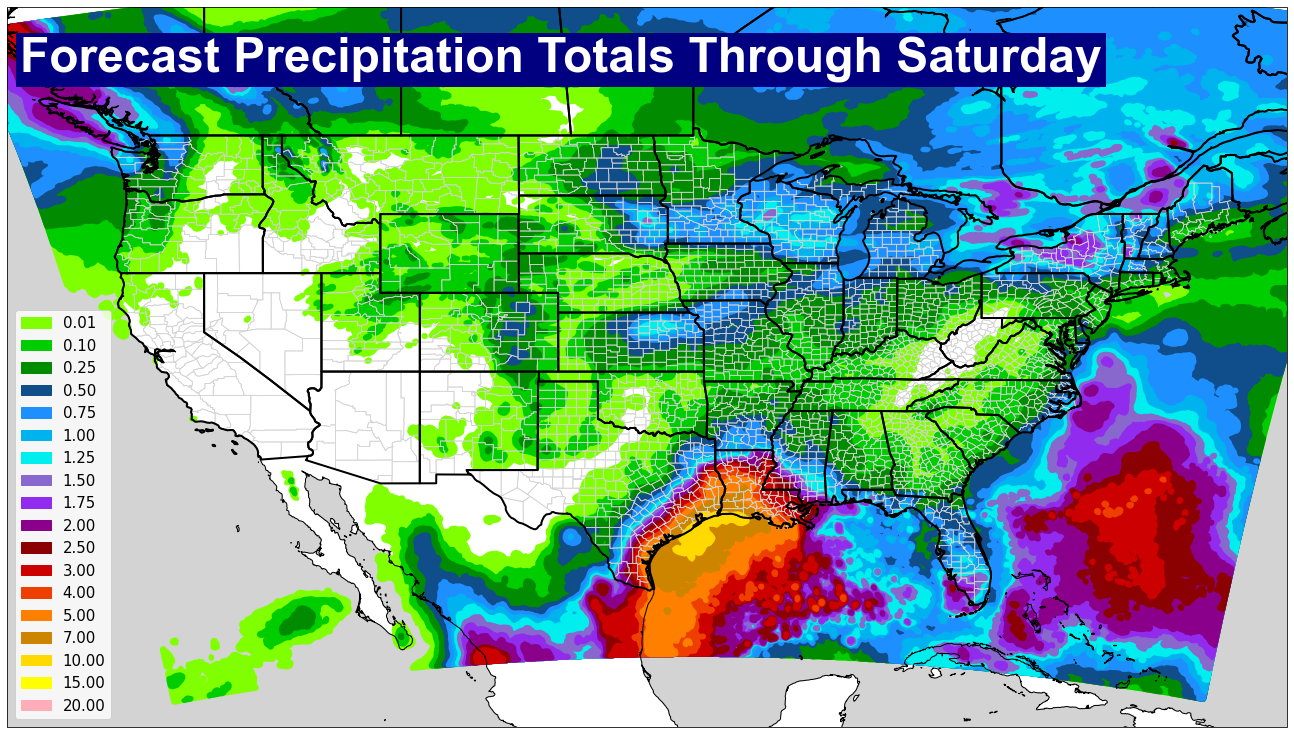

In [27]:
def plot_legend(ax):
    qpf_cmap = wpc_rainfall_categories()
    legend_patches = []
    for val in qpf_cmap.keys():
        patch = mpatches.Patch(color=qpf_cmap[val], label=val)
        legend_patches.append(patch)
    ax.legend(handles=legend_patches, fontsize=15, loc='lower left',)
    
def save_map_to_disk(fig):
    GRAPHICS_DIR = Path('.') / '..' / '..' / 'graphics' / 'wpc'
    fig.savefig(f'{GRAPHICS_DIR}/qpf_{FORECAST}_{LOCATION}.png', dpi=72)

def plot_wpc_qpf_areas():
    new_map = Map(LOCATION)
    new_map.add_counties()
    new_map.remove_international_states()
    new_map.add_title(f'Forecast Precipitation Totals Through {get_qpf_valid_time_info()["valid_day_end"]}')

    fig, ax = new_map.make_map()
    
    qpf_cmap = wpc_rainfall_categories()
    
    for key in qpf_cmap:
        geometries = qpf[qpf['QPF'] == float(key)]
        ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(), facecolor=qpf_cmap[key], 
                          edgecolor=qpf_cmap[key], linewidth=4, zorder=0, alpha=1.0)
    plot_legend(ax)
    save_map_to_disk(fig)
    

plot_wpc_qpf_areas()